In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial'] #set font type
from IPython.display import Image
from compute_interception import daily_interception_threshold
from compute_ET import *
import parameters
from parameters import *
import initialize_parameter_arrays
from data_processing import *
import importlib
import os
from infiltration_models import *

### Read input data

In [122]:
#source directory
src=r"W:\VUB\_main_research\scripts\wetland_model\conceptual_model\data"

#precipitation and ET data
p_ETo=pd.read_csv(os.path.join(src,"Boechout_precip_ETo.csv"), index_col=0)
p_ETo.index=pd.to_datetime(p_ETo.index, format='%d/%m/%Y')
relative_humidity=(pd.read_csv(os.path.join(src,"Boechout_mswx_relative_humidity.csv"), index_col=0))/100
relative_humidity.index=pd.to_datetime(relative_humidity.index, format='%d/%m/%Y')
                            
#observed water table depth data
obs_water_table=pd.read_csv(src+"/monthly_groundwater_depth.csv", index_col=0)
obs_water_table.index=pd.to_datetime(obs_water_table.index)

#surface soil moisture data extracted from SMAP
smap_ssm=pd.read_excel(src+"/smap_surface_sm_boechout_9km.xlsx", index_col=0)
smap_ssm.index=pd.to_datetime(smap_ssm.index)            

#compute components of ET equation

### Initialize arrays based on length of input data

In [123]:
# Reload the module after making changes (if needed)
importlib.reload(parameters)
importlib.reload(initialize_parameter_arrays)

# Initialize arrays based on input data length
init_params=initialize_parameter_arrays.initialized_arrays(p_ETo)

# Update the global namespace with the initialized arrays
globals().update(init_params)

### Set initial values of processes

In [124]:
interception[0]=0.05*LAI

net_precipitation[0]=p_ETo['precipitation'].iloc[0]-interception[0]

s[0]=sfc*0.5 #initial soil moisture content

y[0]=obs_water_table['A3'].iloc[0] #initial water table depth (thickness of unsaturated zone) (cm)

AWC[0]=n*y[0]*(sfc-s[0]) #initial water storage in the soil

water_table_elevation[0]=ref_elev-y[0] #initial groundwater elevation

y_WL[0]=0 #initial water level in wetland

wetland_wl_elev[0]=y_WL[0]+ref_elev_WL #water level in wetland in reference to a datum

A2[0]=(9555.95988+8644.93182)/2
y_rech[0]=0

moisture_dep_factor[0]=0.05

A_ratio[0]=A1/A2[0]

gradient_local[0]=(water_table_elevation[0]-wetland_wl_elev[0])/L_GWlocal #gradient between local gw and wetland

tR_local[0]=L_GWlocal*phi_GWlocal/(Kh_GWlocal*gradient_local[0]) #local response time

qLOCAL_GW[0]=(water_table_elevation[0]-wetland_wl_elev[0])/tR_local[0] #local subsurface flow component

Q_GWreg[0]=Kh_GWreg*((water_table_elevation[0]-wetland_wl_elev[0])/(phi_GW*L_GWreg))

gradient_outflow[0]=(water_table_elevation[0]-wetland_wl_elev[0])/L_GWout # 

tR_out[0]=L_GWout*n/(Kh_GWout*gradient_outflow[0])

qGW_out[0]=(water_table_elevation[0]-wetland_wl_elev[0])/tR_out[0]
run_off[0]=0

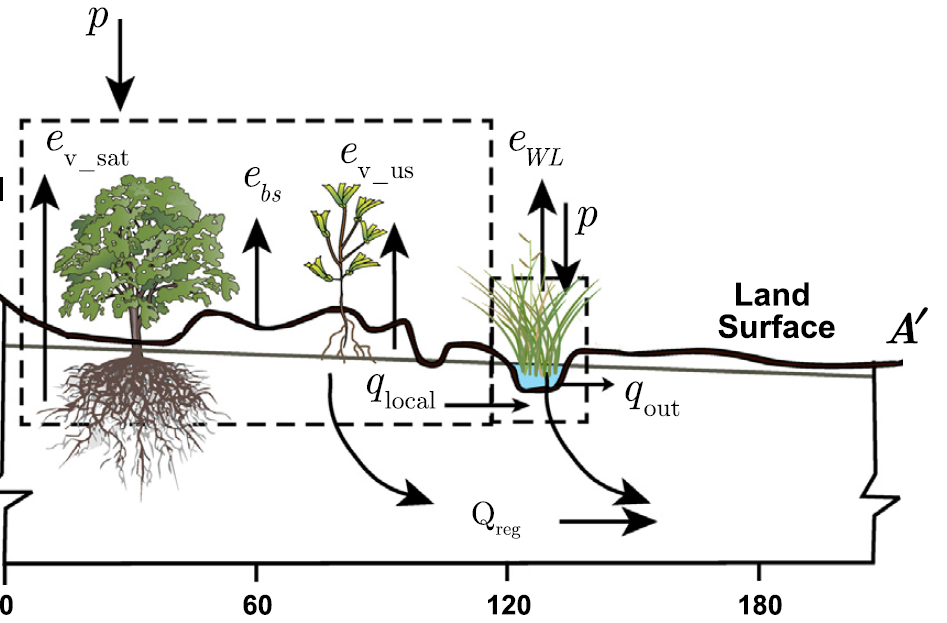

In [125]:
# Displaying the image
img_path = "schematic_representation.png"  # Ensure this file exists in the same directory
Image(filename=img_path, width=400, height=400)

#### Model implementation

In [126]:
s_sce = 0.15
s_molecular_suction = 0.15
dt=1
for time in range(1,len(p_ETo)-1):
    #calculate interception
    #interception_threshold[time]=daily_interception_threshold(p_ETo['precipitation'].iloc[time],a,k_extinct,LAI)

    #Zhang et al., 2002 (An integrated model of soil, hydrology, and vegetation for carbon dynamics in wetland ecosystems)
    interception[time] = min(p_ETo['precipitation'].iloc[time], 0.05*LAI ) 
    
    # Calculate water storage capacity of the soil. 
    # This can be considered as the maximum amount of water the soil can hold at a given time
    AWC[time] = max(0,n * y[time] * (sfc - s[time]))

    # Maximum storage volume of the soil 
    # [Farmer et al., 2000: Climate, soil, and vegetation controls upon the variability of water Downward approach to water balance analysis]

    # Calculate net_precipitation over interception
    if p_ETo['precipitation'].iloc[time] - interception[time] > 0:
        net_precipitation[time] = (p_ETo['precipitation'].iloc[time] - interception[time])*dt
    else:
        net_precipitation[time] = 0
    
    #Calculate cumulative infiltration using the explicit infiltration models for sandy loam soil: 
    # Create an instance of the model
    Ks=25.0 #Saturated hydraulic conductivity in mm/h
    S=53.4 #Sorptivity in mm/h^0.5
    infiltration_model = InfiltrationModel(Ks, S)

   # Calculate cumulative daily infiltration in mm
    daily_infiltration = infiltration_model.valiantzas_model(time) * 24  # converting hourly to daily
    cumulative_infiltration[time] = min(daily_infiltration, net_precipitation[time], AWC[time])

    # Calculate runoff: occurs when net precipitation exceeds cumulative infiltration  
    run_off[time]=max(0,net_precipitation[time] - cumulative_infiltration[time])

    # Update soil moisture content
    #if y[time] != 0:
    # Calculate the change in soil moisture content
    s[time + 1] = s[time] + (cumulative_infiltration[time]) / (n * y[time]) * dt
                    
    """////////////////////// Recharge//////////////////////"""
#=======================================================================================================================
    # Calculate recharge and update soil moisture content
    if cumulative_infiltration[time] >= AWC[time]:
        # Update soil moisture content
        s[time+1] = sfc
        Recharge[time] = cumulative_infiltration[time] - AWC[time]
        # Calculate runoff as the excess water beyond AWC
        run_off[time] = max(0,net_precipitation[time] - cumulative_infiltration[time])

    elif cumulative_infiltration[time] < AWC[time]:
        Recharge[time] = cumulative_infiltration[time] 
        s[time + 1] = s[time] + (cumulative_infiltration[time] / (n * y[time]))

    #Handle edge case where AWC = 0 (saturated soil)
    if AWC[time] == 0:
        Recharge[time] = cumulative_infiltration[time]
        run_off[time] = net_precipitation[time] - cumulative_infiltration[time]
        #y[time + 1] = 0 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    """////////////////////// Soil Moisture//////////////////////"""
    #first update of water table depth. Recharge contribution to water table depth
    #if no recharge, water table depth remains the same. Recharge reduces the depth of the water table
    
    y[time + 1] = y[time] - (Recharge[time] / (n * (1 - sfc))) 
    #n∗(1−sfc) gives the volumetric fraction of the soil that is available for additional water storage (not already filled with water)

    """//////////////////////Evapotranspiration//////////////////////"""
    #Ref: Development of WEP model and its application to an urban watershed Jia et al., 2001 (Hydrological Processes)
    #Evaporation from bare soil is a function of the moisture content of the soil, which is  represented by a wetness function. 
    #soil_evap_numerator[time] is computed from the data_processing.py file
    
    if s[time] <= s_molecular_suction:
        evap_BS[time+1] = 0

    elif s[time] > s_molecular_suction and s[time] < sfc:
        moisture_dep_factor[time] = 0.25 * (1 - np.cos(np.pi * (s[time] - s_molecular_suction) / (sfc - s_molecular_suction))) ** 2
    
        evap_BS[time+1] = soil_evap_numerator.iloc[time]/(delta.iloc[time] + gamma*(1+0.34*(climate_data['wind_speed'].iloc[time]))/moisture_dep_factor[time])
        
    elif s[time] >= sfc:
        evap_BS[time+1] = 0.5* p_ETo['ETo'].iloc[time]

    # Calculate unsaturated zone evaporation
    evap_baresoil[time+1] = (1 - M) * kevap_BS * evap_BS[time]

    if y[time] != 0:
        #calculate the contribution of evaporation from bare soil to soil moisture content
        evap_baresoil_cont_to_s[time] = evap_baresoil[time] / (n * y[time]) * dt

    else:
        evap_baresoil_cont_to_s[time] = 0
    
    #///////////// second update of soil moisture content//////////////////////

    # Update soil moisture content due to unsaturated evaporation
    # When y is zero, indicating the saturated layer is at the surface
    # Set soil moisture content to a maximum value
    # Check if (water table is below the surface)
    if y[time + 1] > 0:  
        s[time + 1] = s[time + 1] - (evap_baresoil_cont_to_s[time] / (n * y[time])) * dt

    else:
       
        s[time] = sfc

    # Calculate plant stress factor: Ref: Development of WEP model and its application to an urban watershed
    if s[time+1] >= s_scs:
        plant_stress_factor[time] = 1
    elif s[time+1] >= s_sce and s[time] < s_scs:
        plant_stress_factor[time] = (s[time] - s_sce) / (s_scs - s_sce)
    else:
        plant_stress_factor[time] = 0

    # Calculate proportion of roots in the unsaturated zone
    if y[time] != 0:
        R_us[time] = np.exp(-(1 / MeanRootDepth) * y[time])
    else:
        R_us[time] = 0

    # Calculate vegetation evaporation from unsaturated zone
    eveg_us[time+1] = M * kveg * plant_stress_factor[time] * (1 - R_us[time]) * p_ETo['ETo'].iloc[time]

    # Contribution to soil moisture from vegetation evaporation
    if y[time] != 0:
        eveg_us_cont_to_s[time] = eveg_us[time] / (n * y[time]) * dt
    else:
        eveg_us_cont_to_s[time] = 0

    #///////////// third and last update of soil moisture content//////////////////////
    # Update soil moisture content due to vegetation evaporation
    if y[time] > 0:  # Check if water table is below the surface
        # Calculate the change in soil moisture
        s[time + 1] =s[time + 1]- (eveg_us[time] / (n * y[time])) * dt
        # Update soil moisture using max() to ensure it remains non-negative
        s[time + 1] = max(s_sce, s[time + 1])

    # else:
    #     # When y is zero, indicating the saturated layer is at the surface
    #     # Set soil moisture content to a maximum value or another appropriate value
    #     s[time + 1] = sfc
    
    """//////////Groundwater flow///////////"""
    # calculate saturated zone evaportanspiration from vegetation
    eveg_sat[time] = M * kvegsat * R_us[time] * p_ETo['ETo'].iloc[time]

    eveg_sat_cont_to_y[time] = eveg_sat[time] / (n * (1 - sfc))

    #local subsurface groundwater flow component
    qLOCAL_GW[time]=(qGW_Local[time]/(n*(1-sfc)))*dt

    #steady state regional groundwater flow
    Qss_GW[time]=(Q_GWreg[time]/(n*(1-sfc)))*dt

     # Update water table depth due to saturated zone evaporation by vegetation
    y[time + 1] += (eveg_sat[time] / (n * (1 - sfc))) * dt

    y[time + 1] += Qss_GW[time] * dt

    y[time + 1] +=  qLOCAL_GW[time] * dt

    # # Ensure the water table does not exceed the surface level
    y[time+1] = max(y[time+1], 0)


    # Calculate groundwater elevation

    water_table_elevation[time+1] = ref_elev - y[time+1]

    """+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++"""
    
    """//////////WETLAND WATER BALANCE///////////"""
    """wetland receives water from precipitation and groundwater flow from the riparian area (qlocal) and loses
       it through evaporation, outflow to the regional groundwater system (Qreg) and local subsurface outflow to the aquifer"""
    
    # Calculate wetland water level
    ep_WL[time] = kv_WL * p_ETo['ETo'].iloc[time] #evaporation from wetland

    # First update of wetland water level: considering only precipitation and evaporation
    net_p_input[time]=p_ETo['precipitation'].iloc[time]-ep_WL[time] #net precipitation input

    y_WL[time + 1] = y_WL[time] + (p_ETo['precipitation'].iloc[time] - ep_WL[time]) * dt #precipitation minus evaporation

    #second update of wetland water level: considering local groundwater inflow from riparian area
    qLOCAL_WL[time]=qGW_Local[time]*A_ratio[time] *dt

    y_WL[time + 1] += qLOCAL_WL[time]

    #third update of wetland water level: considering outflow due to regional groundwater flow
    y_WL[time + 1] -= Q_GWreg[time]*dt #

    y_WL[time + 1] -= qGW_out[time]*dt #

    #y_WL[time + 1] = min(400, y_WL[time + 1])

    # Calculate wetland water level elevation
    wetland_wl_elev[time+1] = y_WL[time+1] + ref_elev_WL

    #Calculation of regional groundwater flow
    Q_GWreg[time+1] = Kh_GWreg * ((water_table_elevation[time+1] - wetland_wl_elev[time+1]) / (phi_GW * L_GWreg))

    if water_table_elevation[time+1] - wetland_wl_elev[time+1] <0:
        Q_GWreg[time+1] = 0

    #----Seepage from wetland to aquifer-----
    gradient_outflow[time+1]=(water_table_elevation[time+1]-wetland_wl_elev[time+1])/L_GWout
    tR_out[time+1]=L_GWout*n/(Kh_GWout*gradient_outflow[time+1])

    if tR_out[time+1]!=0:
        qGW_out[time+1]=(water_table_elevation[time+1]-wetland_wl_elev[time+1])/tR_out[time+1]

    if y_WL[time+1]<=0:
        qGW_out[time+1]=0

    if water_table_elevation[time+1]-wetland_wl_elev[time+1]<0:
        tR_out[time+1]=0
        qGW_out[time+1]=0

    #Local groundwater flow component in groundwater
    gradient_local[time+1]=(water_table_elevation[time+1]-wetland_wl_elev[time+1])/L_GWlocal
    tR_local[time+1]=L_GWlocal*phi_GWlocal/(Kh_GWlocal*gradient_local[time+1])

    if tR_out[time+1]!=0:
        qGW_Local[time+1]=(water_table_elevation[time+1]-wetland_wl_elev[time+1])/tR_local[time+1]


    if water_table_elevation[time+1]-wetland_wl_elev[time+1]<0:
        tR_local[time+1]=0
        qLOCAL_GW[time+1]=0

    # # Calculate wetland area
    if y_WL[time + 1] >= 1400:
        A2[time + 1] = (12128.89561 + 11896.10253) / 2

    elif 1400 > y_WL[time + 1] >= 0:
        A2[time + 1] = (1.267e-14 * y_WL[time + 1] ** 9 - 
                        1.02e-11 * y_WL[time + 1] ** 8 + 
                        3.243e-9 * y_WL[time + 1] ** 7 - 
                        5.098e-7 * y_WL[time + 1] ** 6 + 
                        4.038e-5 * y_WL[time + 1] ** 5 - 
                        0.001458 * y_WL[time + 1] ** 4 + 
                        0.01874 * y_WL[time + 1] ** 3 + 
                        0.5618 * y_WL[time + 1] ** 2 + 
                        6.617 * y_WL[time + 1] + 
                        99.23)

    elif y_WL[time + 1] < 0:
        A2[time + 1] = 62.38497

    # Calculate the ratio of wetland area to catchment area
    A_ratio[time + 1] = A1 / A2[time + 1]

    # Calculate the change in groundwater elevation
    CALCdeltaH_GW[time] = water_table_elevation[time + 1] - water_table_elevation[time]

    # Calculate the change in wetland water level
    CALCdeltaH_WL[time] = wetland_wl_elev[time + 1] - wetland_wl_elev[time]

    # Calculate the change in water table depth
    deltaH_groundwater[time] = y[time + 1] - y[time]

    # Calculate the change in water level in the wetland
    deltaH_wetland[time] = y_WL[time + 1] - y_WL[time]

    # # Calculate the change in soil moisture content
    # if y[time]!=0 and s[time+1]!=0:
    #     Inf_cont_to_s_cm[time] = net_precipitation[time] / (n * y[time])
    #     Inf_cont_to_s_moist[time] = net_precipitation[time] / (n * s[time])

C:\Users\kart\AppData\Local\Temp\ipykernel_34784\1516837463.py:40: RuntimeWarning: invalid value encountered in divide
  s[time + 1] = s[time] + (cumulative_infiltration[time]) / (n * y[time]) * dt


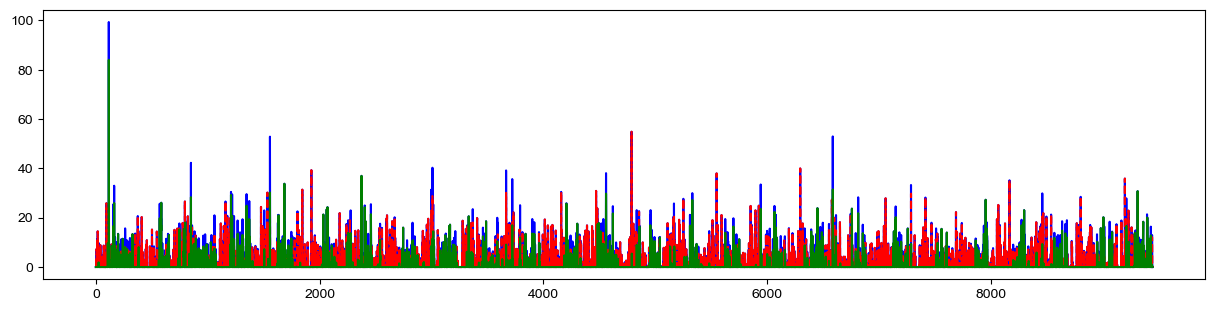

In [127]:
fig, ax = plt.subplots(figsize=(15, 3.5))
plt.plot(net_precipitation[1600:], c='b')
plt.plot(cumulative_infiltration[1600:], c='r',ls='--')
plt.plot(run_off[1600:], c='g')

### Plots

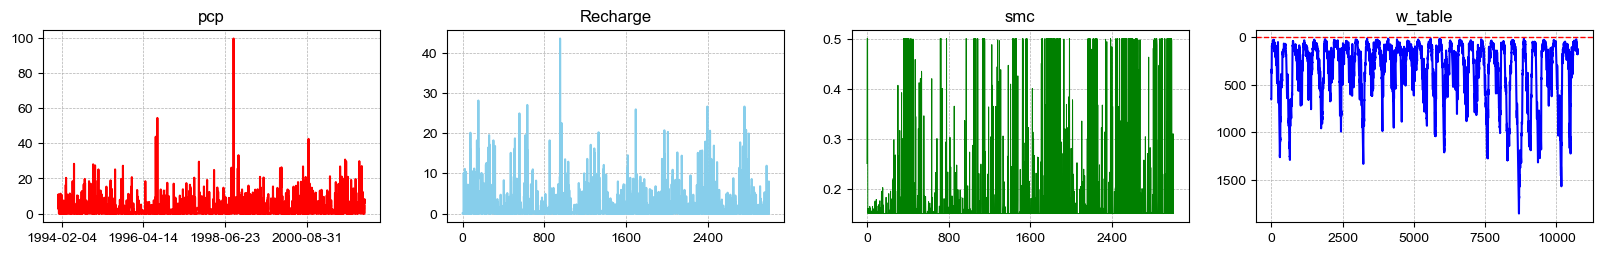

In [128]:
s_df=pd.DataFrame(s)

fig,[ax1,ax2,ax3,ax4]=plt.subplots(1,4,figsize=(20, 2.5))

#set spacing between subplots
plt.subplots_adjust(wspace=0.2)

ax1.plot(p_ETo['precipitation'][0:3000], c='r')
ax2.plot(Recharge[00:3000], c='skyblue')
ax3.plot(s_df[00:3000],c='g', linewidth=0.7)
#ax3.set_ylim(0.1, 0.65)
ax4.plot(y[300:-1], c='b')
ax4.axhline(y=0, color='r', linestyle='--', linewidth=1.0)
#ax3.set_ylim(100, 250)
#invert y axis
ax4.invert_yaxis()
for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    #set grid spacing
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_title(['pcp','Recharge','smc','w_table'][[ax1,ax2,ax3,ax4].index(ax)])

In [129]:
Recharge.mean()*365, eveg_us.mean()*365, eveg_sat.mean()*365, ep_WL.mean()*365

(467.39102680188336, 4.94519165730351, 448.72827429150794, 1064.0903431727634)

#### Compare simulated soil moisture and water table depth with reference data

> Convert model outputs to arrays and aggregate selected variables to monthly intervals

In [130]:
#convert output arrays to dataframes for convenient plotting
output_arrays=[interception,y,Recharge,s,net_precipitation,run_off, qGW_Local, qGW_out, Q_GWreg, eveg_us, eveg_sat, evap_baresoil, evap_BS, ep_WL, net_p_input]

output_df=[pd.DataFrame(arr) for arr in output_arrays]
sim_df=pd.concat(output_df, axis=1)

sim_df.columns=['interception','water_table_depth','recharge','soil_moisture','net_precipitation','run_off','qGW_Local','qGW_out','Q_GWreg','eveg_us','eveg_sat','evap_baresoil','evap_BS','ep_WL','net_p_input']
sim_df.index=p_ETo.index

#Monthly values
s_df_monthly=sim_df['soil_moisture'].resample('ME').mean()
smap_ssm_monthly=smap_ssm.resample('ME').mean()
y_df_monthly=sim_df['water_table_depth'].resample('ME').mean()
obs_water_table_monthly=obs_water_table.resample('ME').mean()

Text(0, 0.5, 'Water table depth (m)')

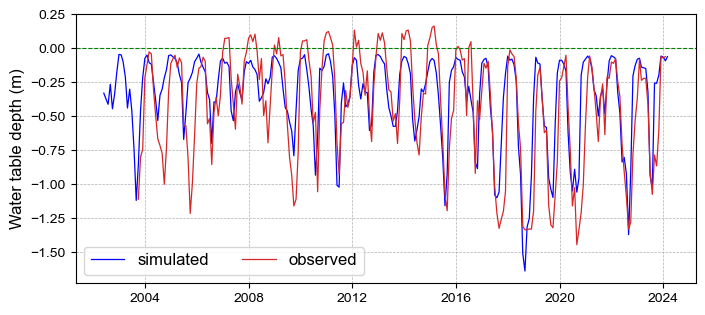

In [131]:
plt.figure(figsize=(8, 3.5))
plt.plot((-1*y_df_monthly[100:-1])/1000, c='b', label='simulated', linewidth=0.9)
plt.plot((-1*obs_water_table['A3']), 'C13', label='observed', linewidth=0.9)
plt.axhline(y=0, color='g', linestyle='--', linewidth=.8)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=12, ncol=2)
plt.ylabel('Water table depth (m)', fontsize=12)

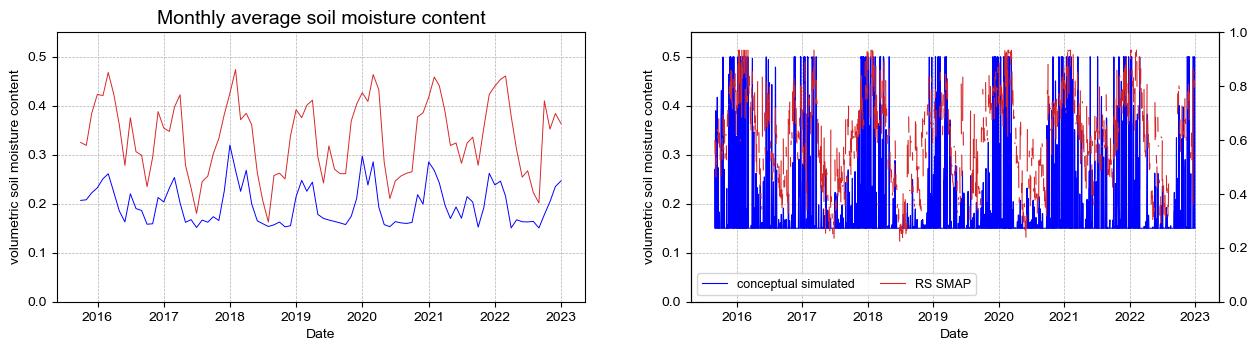

In [132]:
start_date='2015-09-01'
end_date='2022-12-31'


fig,axis=plt.subplots(1,2,figsize=(15, 3.5))
for ax in axis:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    #ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.set_xlabel('Date')
    ax.set_ylabel('volumetric soil moisture content')
    ax.set_ylim(0., 0.55)
    
axis[0].plot((s_df_monthly[start_date:end_date]), c='b', label='conceptual simulated', linewidth=0.7)
axis[0].plot(smap_ssm_monthly[start_date:end_date], 'C13', label='RS SMAP', linewidth=0.7)

axis[1].plot((sim_df['soil_moisture'][start_date:end_date]), c='b', label='conceptual simulated', linewidth=0.8)
axis[1].plot(smap_ssm[start_date:end_date], 'C13', label='RS SMAP', linewidth=0.8)
axis[0].set_title('Monthly average soil moisture content', fontsize=14)
ax.legend(loc='best', fontsize=9, ncols=2)
#plot water table depth on secondary y-axis
ax2=axis[1].twinx()
# ax2.plot((obs_water_table_monthly['A3'][start_date:end_date]), c='c', label='water table depth', linewidth=0.7);
# ax2.plot((y_df_monthly[start_date:end_date])/1000, c='r', label='water table depth', linewidth=0.7);

(0.0, 0.55)

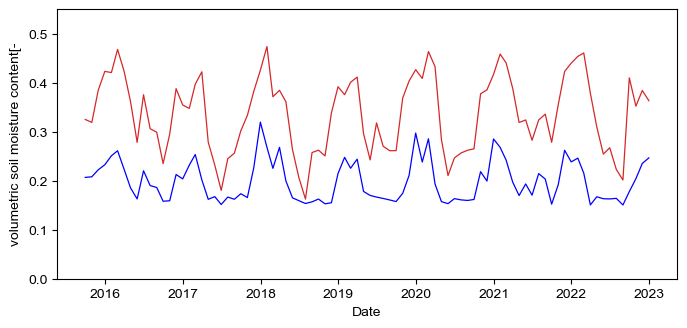

In [133]:
fig,axis=plt.subplots(figsize=(8.0, 3.5))

#ax.xaxis.set_major_locator(plt.MaxNLocator(6))
plt.plot((s_df_monthly[start_date:end_date]), c='b', label='conceptual simulated', linewidth=0.9)
plt.plot(smap_ssm_monthly[start_date:end_date], 'C13', label='RS SMAP', linewidth=0.9)

plt.xlabel('Date')
plt.ylabel('volumetric soil moisture content[-')
plt.ylim(0., 0.55)

Correlation coefficient: 0.796


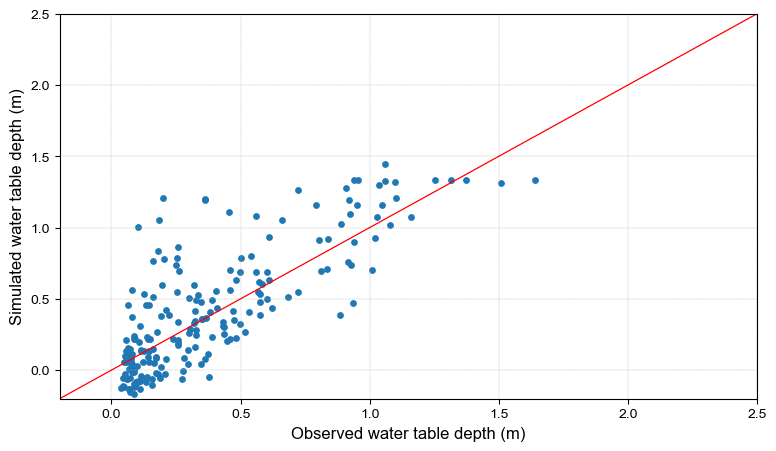

In [134]:
#scatter plot of observed and simulated water table depth
plt.figure(figsize=(9, 5))
plt.scatter(y_df_monthly['2007-01-01':'2023-12-31']/1000, obs_water_table_monthly['A3']['2007-01-01':'2023-12-31'],s=15)
plt.xlabel('Observed water table depth (m)', fontsize=12)
plt.ylabel('Simulated water table depth (m)', fontsize=12)

#calculate correlation coefficient
corr = np.corrcoef(obs_water_table_monthly['A3']['2007-01-01':'2023-12-31'],y_df_monthly['2007-01-01':'2023-12-31'])
#add 1:1 line
plt.plot([-.2, 2.5], [-0.2, 2.5], 'r', linewidth=0.9)
plt.ylim(-0.2, 2.5)
plt.xlim(-0.2, 2.5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3) 
print('Correlation coefficient:', np.round(corr[0, 1],3))

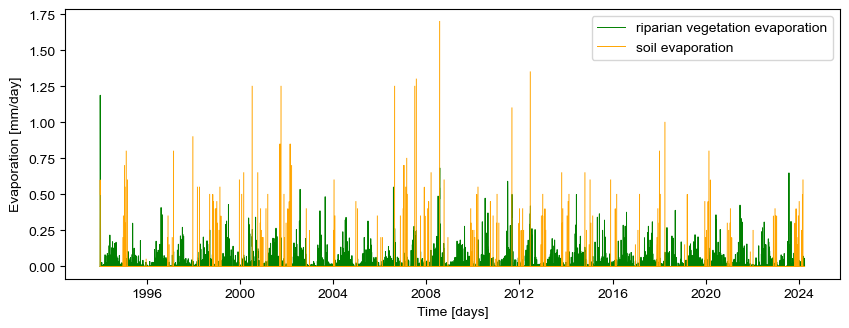

In [135]:
fig, ax = plt.subplots(figsize=(10, 3.5))
#plt.plot(np.squeeze(ep_WL), c='skyblue', linewidth=0.7, label='Wetland evaporation')
plt.plot(sim_df['eveg_us'], c='green', linewidth=0.7, label='riparian vegetation evaporation')
plt.plot(sim_df['evap_BS'], linewidth=0.7, c='orange', label='soil evaporation')
#plt.plot(p_ETo['ETo'], c='purple', linewidth=0.7, label='potential_evapotranspiration')
plt.ylabel('Evaporation [mm/day]')
plt.xlabel('Time [days]')
plt.legend(loc='best')

Text(0.5, 0, '')

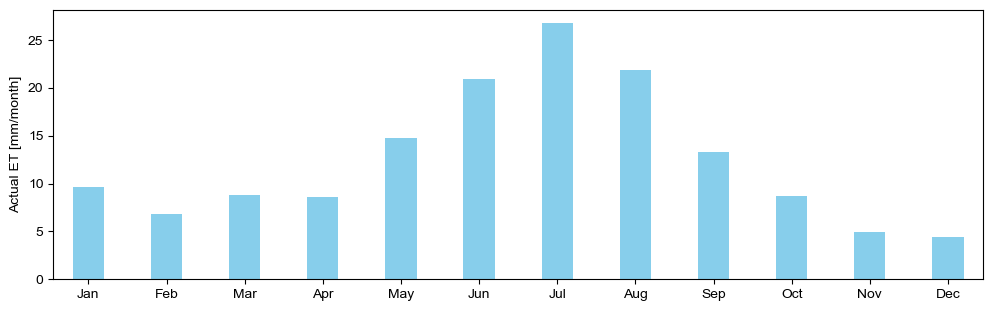

In [136]:
em_df = sim_df['eveg_us'].resample('ME').sum()
e_mon_df = em_df.groupby(em_df.index.month).sum()
e_mon_df.plot(kind='bar', figsize=(12, 3.5), color='skyblue', width=0.4)
#rename x-axis ticks
plt.xticks(np.arange(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0);
plt.ylabel('Actual ET [mm/month]')
plt.xlabel('')

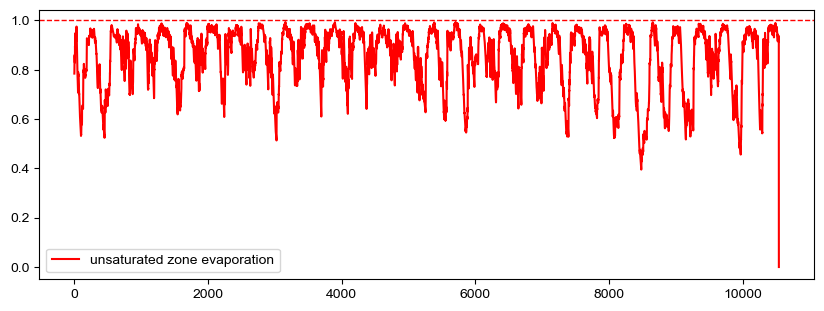

In [137]:
fig, ax = plt.subplots(figsize=(10, 3.5))
# plt.plot(np.squeeze(water_table_elevation[10:]), c='g', label="water table elevation")
plt.plot(R_us[500:], c='r', label="unsaturated zone evaporation")
plt.legend(loc='best')
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.0)

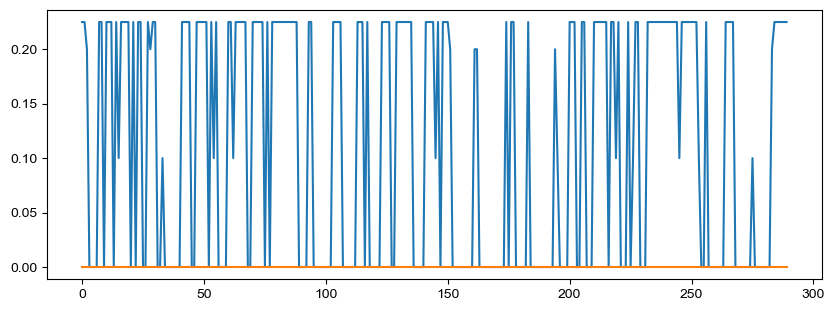

In [138]:
fig, ax = plt.subplots(figsize=(10, 3.5))
plt.plot(np.squeeze(interception[10:300]))
plt.plot(np.squeeze(interception_threshold[10:300]))

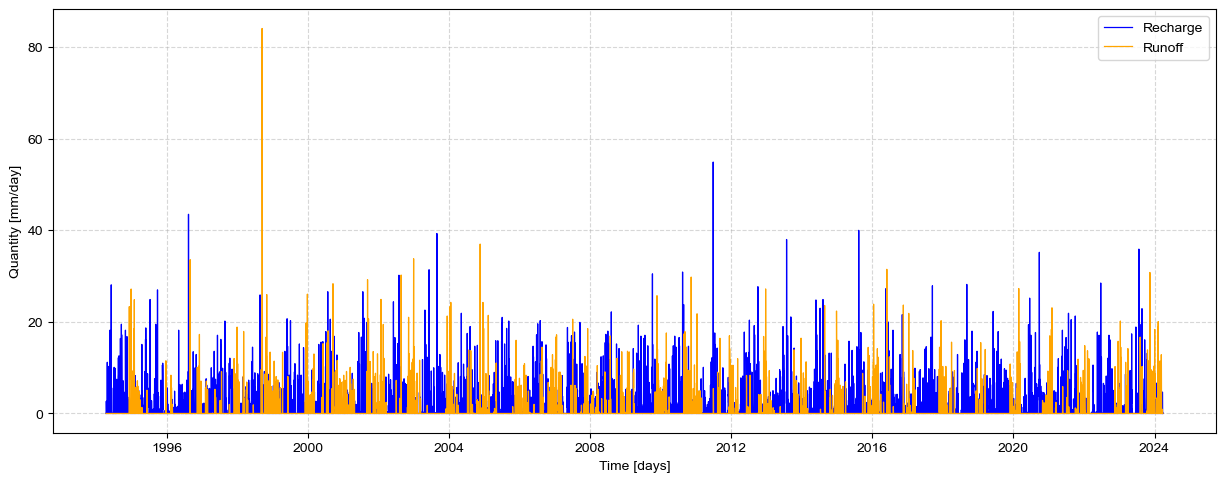

In [139]:

recharge_df=pd.DataFrame(Recharge, columns=['Recharge'])
run_off_df=pd.DataFrame(run_off, columns=['run_off'])
run_off_df.index=p_ETo.index

recharge_df.index=p_ETo.index


plt.figure(figsize=(15, 5.5))
#plt.plot(Recharge, c='r')
plt.plot(recharge_df[100:], c='blue', linewidth=0.9, label='Recharge')
plt.plot(run_off_df[100:], c='orange', linewidth=0.9, label='Runoff')
#plt.ylim(0.05, 0.55)
#plt.ylabel('Volumetric coil Moisture Content[-]')
plt.ylabel('Quantity [mm/day]')
plt.xlabel('Time [days]')
plt.grid(alpha=0.5, linestyle='--') 
plt.legend(loc='best')

### Groundwater Fluxes

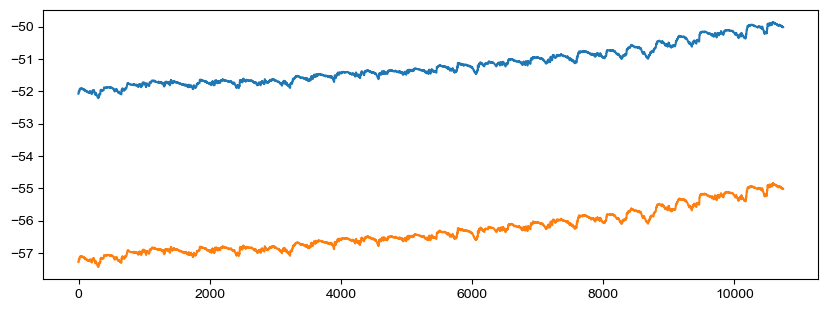

In [140]:
plt.figure(figsize=(10, 3.5))
plt.plot(np.squeeze(gradient_local[300:]))
plt.plot(np.squeeze(gradient_outflow[300:]))
# plt.plot(Q_GWreg[10:])
# plt.plot(Qss_GW[10:])

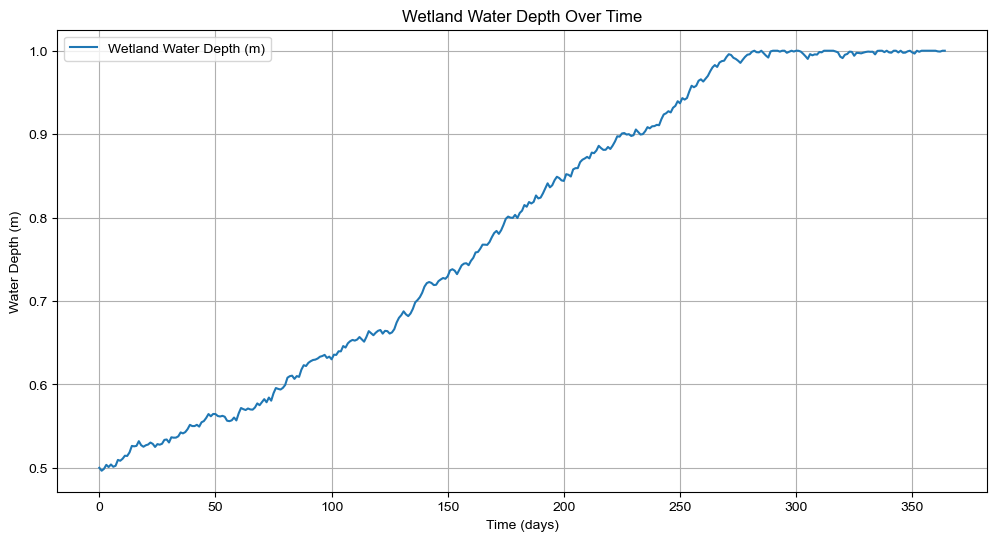

In [141]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants and parameters
dt = 1  # time step in days
time_steps = 365  # simulation for one year
initial_depth = 0.5  # initial water depth in meters

# Fluxes (example values, replace with actual data)
precipitation = np.random.uniform(0, 0.01, time_steps)  # daily precipitation in meters
transpiration = np.random.uniform(0, 0.005, time_steps)  # daily transpiration in meters
outflow = np.random.uniform(0, 0.002, time_steps)  # daily outflow in meters

# Initialize arrays
depth = np.zeros(time_steps)
depth[0] = initial_depth

# Simulation loop
for t in range(1, time_steps):
    P = precipitation[t]
    T = transpiration[t]
    O = outflow[t]
    delta_h = (P - T - O) * dt
    depth[t] = depth[t-1] + delta_h

    # Ensure the depth does not exceed 1 meter
    if depth[t] > 1:
        depth[t] = 1

    # Ensure the depth does not go below 0
    if depth[t] < 0:
        depth[t] = 0

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(depth, label='Wetland Water Depth (m)')
plt.xlabel('Time (days)')
plt.ylabel('Water Depth (m)')
plt.title('Wetland Water Depth Over Time')
plt.legend()
plt.grid()
plt.show()

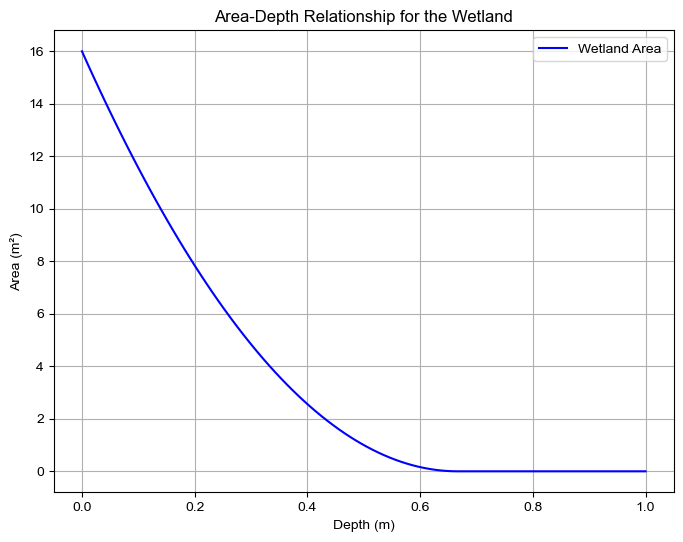

In [142]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function to calculate the area at a given depth
def calculate_area(depth, W_top, L_top, slope_ratio):
    W = W_top - 6 * depth
    L = L_top - 6 * depth
    if W <= 0 or L <= 0:
        return 0  # if dimensions go negative, area is zero (this handles edge cases)
    return W * L

# Wetland top dimensions and slope ratio
W_top = 4  # meters
L_top = 4  # meters
slope_ratio = 3  # 1:3 slope

# Generate a range of depths from 0 to 1 meter
depths = np.linspace(0, 1, 100)

# Calculate the corresponding areas
areas = [calculate_area(depth, W_top, L_top, slope_ratio) for depth in depths]

# Plot the area-depth relationship
plt.figure(figsize=(8, 6))
plt.plot(depths, areas, label='Wetland Area', color='blue')
plt.xlabel('Depth (m)')
plt.ylabel('Area (m²)')
plt.title('Area-Depth Relationship for the Wetland')
plt.legend()
plt.grid()
plt.show()


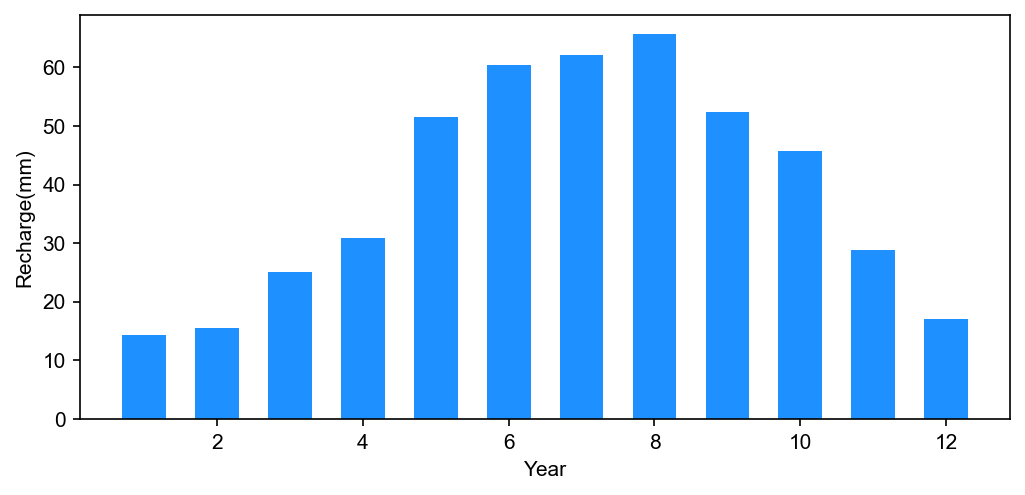

In [143]:

plt.figure(figsize=(8, 3.5), dpi=150)
data = sim_df[['net_precipitation', 'recharge']].resample('ME').sum()
data_monthly = data.groupby(data.index.month).mean()

# If you want a bar plot for recharge:
plt.bar(data_monthly.index, data_monthly['recharge'], color='dodgerblue', label='Recharge', width=0.6)  # Adjust width if necessary
#plt.legend()
plt.xlabel('Year')
plt.ylabel('Recharge(mm)')

plt.show()